In [21]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

In [22]:
# Load and prepare data
df = pd.read_csv(r"D:\JOB\1 Pricing analyst\1 Price elasticity & demand forecasting\2 Time series\time_series_dataset.csv")

In [23]:
df

,date,price,demand,competitor_price,economic_index,promotion,day_of_week,month,year,quarter,week_of_year,demand_moving_avg,price_change,demand_lag_1
0,2015-01-01,20.248357,391.973267,18.448952,0.725858,0,3,1,2015,1,1,391.973267,0.000000,400.140680
1,2015-01-02,19.977995,397.369221,21.918927,1.215202,0,4,1,2015,1,1,394.671244,-0.013352,391.973267
2,2015-01-03,20.418086,392.564124,21.643247,0.971469,0,5,1,2015,1,1,393.968871,0.022029,397.369221
3,2015-01-04,20.902848,397.532455,22.444680,0.981343,0,6,1,2015,1,1,394.859767,0.023742,392.564124
4,2015-01-05,20.071314,412.871847,20.851262,0.994398,0,0,1,2015,1,2,398.462183,-0.039781,397.532455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2024-12-27,22.457577,334.384420,21.307931,1.216404,0,4,12,2024,4,52,343.590089,0.014432,328.907557
3649,2024-12-28,21.884491,356.342412,22.925660,1.478020,0,5,12,2024,4,52,346.055292,-0.025519,334.384420
3650,2024-12-29,22.337475,351.571590,23.392111,1.409487,0,6,12,2024,4,52,347.936115,0.020699,356.342412
3651,2024-12-30,22.441717,364.623727,21.438130,1.358251,1,0,12,2024,4,1,347.758898,0.004667,351.571590


In [24]:
# Preprocess
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df.rename(columns={"date": "ds", "demand": "y"}, inplace=True)

In [25]:
# Define regressors and scale them
regressors = ["competitor_price", "economic_index", "promotion"]
scaler = StandardScaler()
df[regressors] = scaler.fit_transform(df[regressors])

In [26]:
# Train-test split (reduced forecast horizon to 90 for better short-term accuracy)
train = df[:-90]
test = df[-90:]


In [27]:
# Build Prophet model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='additive',
    changepoint_prior_scale=0.2,         # 🔧 Increased for flexibility
    seasonality_prior_scale=10.0         # 🔧 Boosted to capture seasonality better
)

In [28]:
# Add regressors
for reg in regressors:
    m.add_regressor(reg, mode="additive")

In [29]:
# Fit model
m.fit(train)

10:39:01 - cmdstanpy - INFO - Chain [1] start processing
10:39:11 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Create future dataframe
future = m.make_future_dataframe(periods=90)
for reg in regressors:
    future[reg] = df[reg]

In [31]:
# Forecast
forecast = m.predict(future)

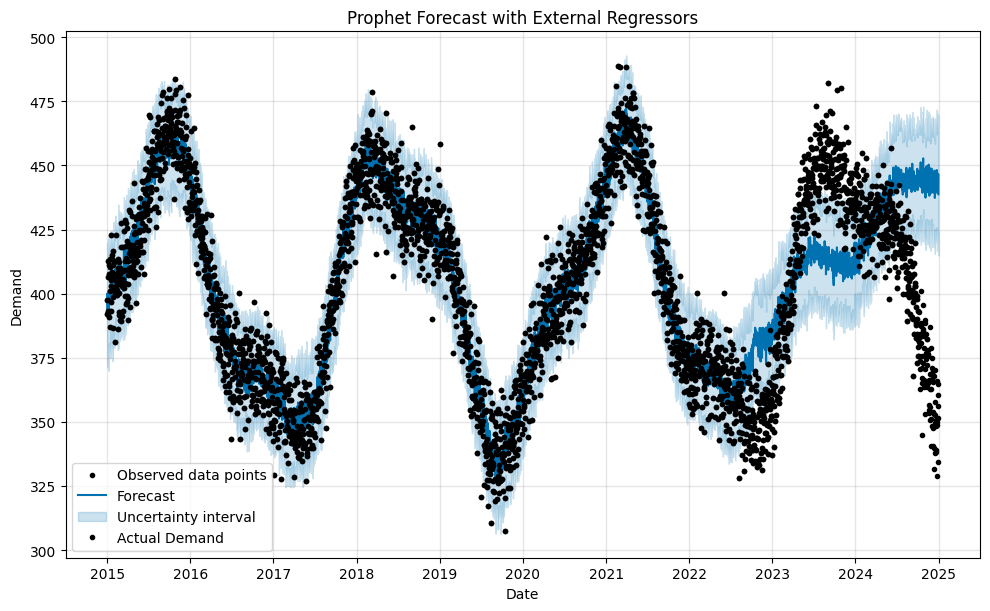

In [32]:
# Plot forecast
fig = m.plot(forecast)
plt.plot(df["ds"], df["y"], "k.", label="Actual Demand")
plt.title("Prophet Forecast with External Regressors")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()

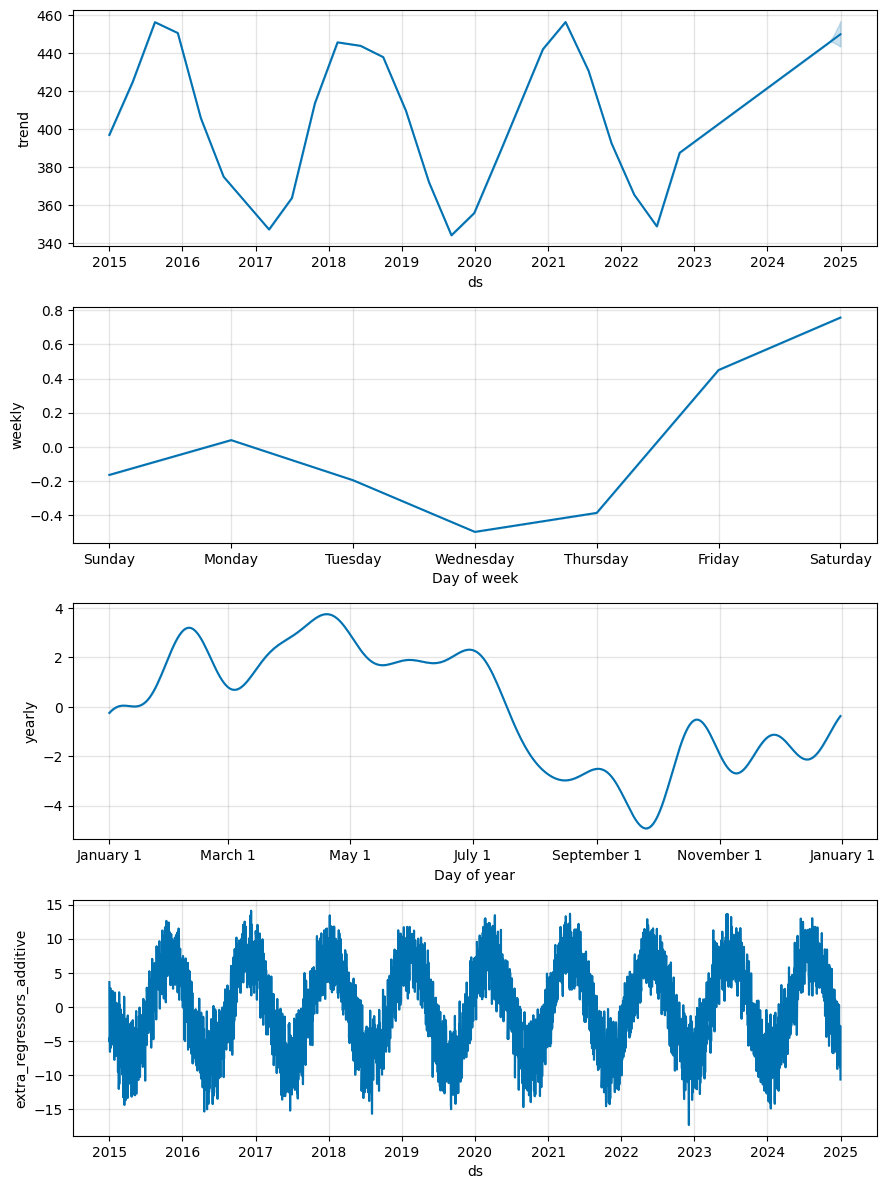

In [33]:
# Plot components
m.plot_components(forecast)
plt.show()

In [34]:
# Evaluate on test set
forecast_test = forecast.set_index("ds").loc[test["ds"]]
merged = forecast_test.join(test.set_index("ds")[["y"]])
rmse = sqrt(mean_squared_error(merged["y"], merged["yhat"]))
print(f"✅ RMSE on test set: {rmse:.2f}")


✅ RMSE on test set: 79.41
